In [29]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import json
import csv
# thumbnaille bench execution

### Energy

In [30]:
def max_abs_scale(series):
    return series / series.abs().max()
bar_width = 0.18

In [31]:
headers = ['duration_seconds', 'cpu0_package_joules', 'cpu0_dram_joules', 'cpu1_package_joules', 'cpu1_dram_joules', 'video', 'library']
data = []

for dir in os.listdir("../result/energy"):
    dir_path = os.path.join("../result/energy", dir)
    video = dir.replace(".avi", "")

    for file in os.listdir(dir_path):
        file_paht = os.path.join(dir_path, file)
        library = file.replace(video+".avi.txt", "")

        with open(file_paht, 'r') as file:
            lines = file.readlines()
            
        for line in lines:
                line = line.strip()
                if line.startswith('duration_seconds'):
                    duration_seconds = line.split('=')[1]
                elif line.startswith('cpu0_package_joules'):
                    cpu0_package_joules = line.split('=')[1]
                elif line.startswith('cpu0_dram_joules'):
                    cpu0_dram_joules = line.split('=')[1]
                elif line.startswith('cpu1_package_joules'):
                    cpu1_package_joules = line.split('=')[1]
                elif line.startswith('cpu1_dram_joules'):
                    cpu1_dram_joules = line.split('=')[1]

                    # Append the extracted values to the data list
                    data.append([duration_seconds, 
                                 cpu0_package_joules, 
                                 cpu0_dram_joules, 
                                 cpu1_package_joules, 
                                 cpu1_dram_joules, 
                                 video, 
                                 library])

    with open("energy.csv", 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write the header
        writer.writerows(data)    # Write the data

In [32]:
df = pd.read_csv("energy.csv")
df["energy"] = df["cpu0_package_joules"] + df["cpu1_package_joules"]
# df.head()

video_order = ["36Kb", "540Kb", "1Mb", "6Mb"]

color_mapping = {
    "moviepy": "#17becf",
    "ffmpeg": "#ff7f0e",
    "imageio": "#f0e68c",
    "opencv": "#27ae60"
}

bar_width = 0.16

def max_abs_scale(series):
    return series / series.abs().max()

df.head()

,duration_seconds,cpu0_package_joules,cpu0_dram_joules,cpu1_package_joules,cpu1_dram_joules,video,library,energy
0,3.133993,340.970947,41.502168,328.044556,38.892615,540Kb,moviepy,669.015503
1,2.734248,293.735596,36.142410,281.837952,33.876449,540Kb,moviepy,575.573548
2,2.799723,300.128784,36.919405,289.265625,34.965105,540Kb,moviepy,589.394409
3,2.820718,301.977661,37.232642,291.449158,35.172298,540Kb,moviepy,593.426819
4,2.749044,294.714294,36.226009,283.866882,34.329513,540Kb,moviepy,578.581176


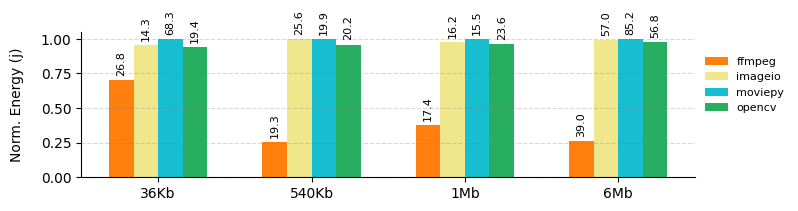

In [34]:
dftt = df.copy()

mean_df = dftt.groupby(['library', 'video'], as_index=False)['energy'].mean()
mean_df.rename(columns={'energy': 'mean_energys'}, inplace=True)
std_df = dftt.groupby(['library', 'video'], as_index=False)['energy'].std()
std_df.rename(columns={'energy': 'std_energy'}, inplace=True)

dftt = std_df.merge(mean_df, on=['library', 'video'])

dfe_max_abs = dftt.copy()

dfe_max_abs['mean_energys'] = dfe_max_abs.groupby('video')['mean_energys'].transform(max_abs_scale)

dfe_max_abs['video'] = pd.Categorical(dfe_max_abs['video'], categories=video_order, ordered=True)

dfe_max_abs = dfe_max_abs.sort_values(['library', 'video'])

# Define the libraries and video sizes
libraries = dfe_max_abs['library'].unique()
video_sizes = dfe_max_abs['video'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(video_sizes))

# Plot each video size
for i, library in enumerate(libraries):
    subset = dfe_max_abs[dfe_max_abs['library'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['mean_energys'], width=bar_width, label=library, color=color_mapping[library])

    for bar, std in zip(bars, subset['std_energy']):
        height = bar.get_height()
        ax.annotate(f'{std:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

# Set the labels and title
ax.set_ylabel('Norm. Energy (j)', fontsize=10, labelpad=12)
ax.spines[['right', 'top']].set_visible(False)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(video_sizes)

ax.legend(
    bbox_to_anchor=(1, 0.9), loc='upper left', ncols = 1, frameon=False, fontsize=8
)

# plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Others Metric's 

In [35]:
def parse_json_objects(log_content):
    json_objects = []
    buffer = ""
    brace_count = 0

    for char in log_content:
        buffer += char
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
        
        if brace_count == 0 and buffer.strip():
            try:
                json_objects.append(json.loads(buffer.strip()))
                buffer = ""
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                buffer = ""

    return json_objects

# Read the contents of the log file
with open('../result/result.txt', 'r') as file:
    log_content = file.read()

# Parse the log content into JSON objects
json_objects = parse_json_objects(log_content)

# Define the CSV file headers
headers = ["compute_time", "download_size", "download_time", "video", "library", "upload_size", "upload_time"]

# Open the CSV file for writing
with open('result.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()

    # Process each JSON object
    for data in json_objects:
        try:
            # Write the row to the CSV file
            writer.writerow({
                "compute_time": data["compute_time"],
                "download_size": data["download_size"],
                "download_time": data["download_time"],
                "video": data["video"].replace(".avi", ""),
                "library": data["library"],
                "upload_size": data["upload_size"],
                "upload_time": data["upload_time"]
            })
        except KeyError as e:
            print(f"Missing key in data: {e}")

print("CSV file has been created successfully.")


CSV file has been created successfully.


#### Compute Time

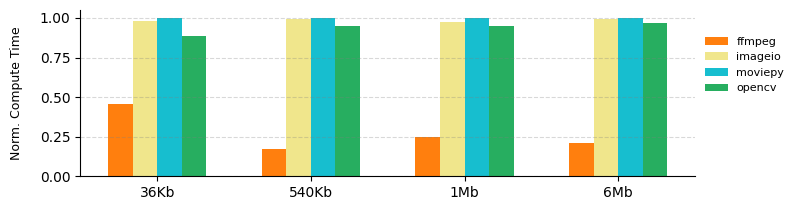

In [36]:
df = pd.read_csv("result.csv")

dfct = df.copy()

dfct = dfct.groupby(['library', 'video'], as_index = False)['compute_time'].mean()

dfct['normalized_compute_time'] = dfct.groupby('video')['compute_time'].transform(max_abs_scale)

dfct['video'] = pd.Categorical(dfct['video'], categories=video_order, ordered=True)

dfct = dfct.sort_values(['library', 'video'])

# Define the libraries and video sizes
libraries = dfct['library'].unique()
video_sizes = dfct['video'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(video_sizes))

# Plot each video size
for i, library in enumerate(libraries):
    subset = dfct[dfct['library'] == library]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_compute_time'], width=bar_width, label=library, color=color_mapping[library])

# Set the labels and title
ax.set_ylabel('Norm. Compute Time', fontsize=9, labelpad=12)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)


ax.spines[['right', 'top']].set_visible(False)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(video_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.9), loc='upper left', ncols = 1, frameon=False, fontsize=8
)

# plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Upload Size

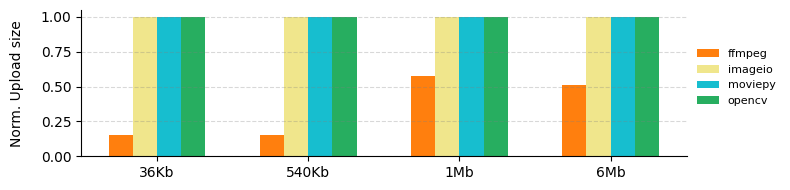

In [37]:
dfus = df.copy()

dfus = dfus.groupby(['library', 'video'], as_index = False)['upload_size'].mean()

dfus['normalized_upload_size'] = dfus.groupby('video')['upload_size'].transform(max_abs_scale)

dfus['video'] = pd.Categorical(dfus['video'], categories=video_order, ordered=True)

dfus = dfus.sort_values(['library', 'video'])

libraries = dfus['library'].unique()
video_sizes = dfus['video'].unique()

fig, ax = plt.subplots(figsize=(8, 2))

# Plot each video size
for i, library in enumerate(libraries):
    subset = dfus[dfus['library'] == library]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_upload_size'], width=bar_width, label=library, color=color_mapping[library])

ax.set_ylabel('Norm. Upload size', fontsize=10, labelpad=12)
ax.spines[['right', 'top']].set_visible(False)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(video_sizes)

ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=8
)

plt.tight_layout()
plt.show()


#### Total Time

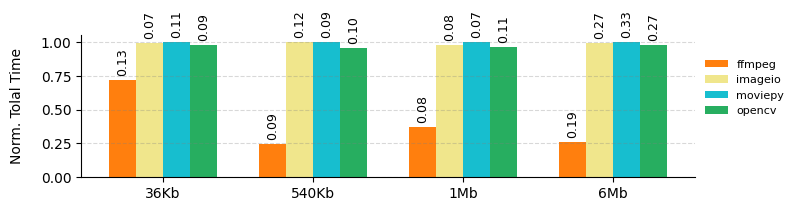

In [38]:
bar_width = 0.18

df["total_time"] = df["compute_time"] + df["upload_time"] + df["download_time"]

dftt = df.copy()

mean_df = dftt.groupby(['library', 'video'], as_index=False)['total_time'].mean()
mean_df.rename(columns={'total_time': 'mean_total_time'}, inplace=True)
std_df = dftt.groupby(['library', 'video'], as_index=False)['total_time'].std()
std_df.rename(columns={'total_time': 'std_total_time'}, inplace=True)

dftt = std_df.merge(mean_df, on=['library', 'video'])

dftt['normalized_total_time'] = dftt.groupby('video')['mean_total_time'].transform(max_abs_scale)

dftt['video'] = pd.Categorical(dftt['video'], categories=video_order, ordered=True)

dftt = dftt.sort_values(['library', 'video'])

libraries = dftt['library'].unique()
video_sizes = dftt['video'].unique()

fig, ax = plt.subplots(figsize=(8, 2.2))

positions = np.arange(len(video_sizes))

for i, library in enumerate(libraries):
    subset = dftt[dftt['library'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['normalized_total_time'], width=bar_width, label=library, color=color_mapping[library])

    for bar, std in zip(bars, subset['std_total_time']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, rotation=90)

ax.set_ylabel('Norm. Tolal Time', fontsize=10, labelpad=12)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(video_sizes)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

ax.legend(
    bbox_to_anchor=(1, 0.9), loc='upper left', ncols = 1, frameon=False, fontsize=8
)

plt.tight_layout()
plt.show()